In [0]:
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm import tqdm
import imghdr
import random
import torchvision.transforms as transforms
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import DataLoader
from torch.optim import Adadelta, Adam
from torch.nn import BCELoss, DataParallel
from torchvision.utils import save_image
import argparse
import json
import time
import shutil
import os
import zipfile

In [0]:
if(os.path.isdir('data_faces')):
    shutil.rmtree('data_faces')
if(os.path.isdir('results')):
    shutil.rmtree('results')

!mkdir results

In [26]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
    zip_ref.extractall("data_faces/")

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

--2020-03-30 11:16:07--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.8
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.1’

celeba.zip.1        100%[===================>]   1.34G  76.5MB/s    in 18s     

2020-03-30 11:16:25 (77.8 MB/s) - ‘celeba.zip.1’ saved [1443490838/1443490838]

202599


In [27]:
parser = argparse.ArgumentParser()
data_dir = 'data_faces/img_align_celeba'
split = 0.8
data_dir = os.path.expanduser(data_dir)
print(len(os.listdir(data_dir)))

202599


In [28]:
print('loading dataset...')
src_paths = []
ite = 0
tp = time.time() 
for file in os.listdir(data_dir):
    ite += 1
    if (ite % 10000 == 0):
        print(time.time()-tp)
    path = os.path.join(data_dir, file)
    # if imghdr.what(path) == None:
    #     continue
    src_paths.append(path)
random.shuffle(src_paths)

# separate the paths
border = int(split * len(src_paths))
train_paths = src_paths[:border]
test_paths = src_paths[border:]
print('train images: %d images.' % len(train_paths))
print('test images: %d images.' % len(test_paths))

# create dst directories
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
if os.path.exists(train_dir) == False:
    os.makedirs(train_dir)
if os.path.exists(test_dir) == False:
    os.makedirs(test_dir)

# move the image files
pbar = tqdm(total=len(src_paths))
for dset_paths, dset_dir in zip([train_paths, test_paths], [train_dir, test_dir]):
    for src_path in dset_paths:
        dst_path = os.path.join(dset_dir, os.path.basename(src_path))
        shutil.move(src_path, dst_path)
        pbar.update()
pbar.close()

print(len(os.listdir('data_faces/img_align_celeba/train')))
print(len(os.listdir('data_faces/img_align_celeba/test')))

loading dataset...
0.10575270652770996
0.11826109886169434
0.13084936141967773
0.14357495307922363
0.1591501235961914
0.1748807430267334
0.18816113471984863
0.20336437225341797
0.2176978588104248
0.23121023178100586
0.24385857582092285
0.2569725513458252
0.2697751522064209
0.2824981212615967
0.2958557605743408
0.30811381340026855
0.322843074798584
0.335918664932251
0.34859704971313477
0.360980749130249


  0%|          | 0/202599 [00:00<?, ?it/s]

train images: 162079 images.
test images: 40520 images.


100%|██████████| 202599/202599 [00:06<00:00, 30463.96it/s]

162079
40520


In [0]:
class ImageDataset(data.Dataset):
    def __init__(self, data_dir, transform=None, recursive_search=False):
        super(ImageDataset, self).__init__()
        self.data_dir = os.path.expanduser(data_dir)
        self.transform = transform
        self.imgpaths = self.__load_imgpaths_from_dir(self.data_dir, walk=recursive_search)

    def __len__(self):
        return len(self.imgpaths)

    def __getitem__(self, index, color_format='RGB'):
        img = Image.open(self.imgpaths[index])
        img = img.convert(color_format)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __is_imgfile(self, filepath):
        filepath = os.path.expanduser(filepath)
        if os.path.isfile(filepath) and imghdr.what(filepath):
            return True
        else:
            return False

    def __load_imgpaths_from_dir(self, dirpath, walk=False, allowed_formats=None):
        imgpaths = []
        dirpath = os.path.expanduser(dirpath)
        if walk:
            for (root, dirs, files) in os.walk(dirpath):
                for file in files:
                    file = os.path.join(root, file)
                    if self.__is_imgfile(file):
                        imgpaths.append(file)
        else:
            for path in os.listdir(dirpath):
                path = os.path.join(dirpath, path)
                if self.__is_imgfile(path) == False:
                    continue
                imgpaths.append(path)
        return imgpaths

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)


class Concatenate(nn.Module):
    def __init__(self, dim=-1):
        super(Concatenate, self).__init__()
        self.dim = dim

    def forward(self, x):
        return torch.cat(x, dim=self.dim)

In [0]:
from torch.nn.functional import mse_loss    

def completion_network_loss(input, output, mask):
    return mse_loss(output * mask, input * mask)

In [0]:
class CompletionNetwork(nn.Module):
    def __init__(self):
        super(CompletionNetwork, self).__init__()
        # input_shape: (None, 4, img_h, img_w)
        self.conv1 = nn.Conv2d(4, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h, img_w)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.act3 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.act4 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.act5 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.act6 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=2, padding=2)
        self.bn7 = nn.BatchNorm2d(256)
        self.act7 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=4, padding=4)
        self.bn8 = nn.BatchNorm2d(256)
        self.act8 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv9 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=8, padding=8)
        self.bn9 = nn.BatchNorm2d(256)
        self.act9 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=3, stride=1, dilation=16, padding=16)
        self.bn10 = nn.BatchNorm2d(256)
        self.act10 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv11 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.act11 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.conv12 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn12 = nn.BatchNorm2d(256)
        self.act12 = nn.ReLU()
        # input_shape: (None, 256, img_h//4, img_w//4)
        self.deconv13 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bn13 = nn.BatchNorm2d(128)
        self.act13 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn14 = nn.BatchNorm2d(128)
        self.act14 = nn.ReLU()
        # input_shape: (None, 128, img_h//2, img_w//2)
        self.deconv15 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn15 = nn.BatchNorm2d(64)
        self.act15 = nn.ReLU()
        # input_shape: (None, 64, img_h, img_w)
        self.conv16 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn16 = nn.BatchNorm2d(32)
        self.act16 = nn.ReLU()
        # input_shape: (None, 32, img_h, img_w)
        self.conv17 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.act17 = nn.Sigmoid()
        # output_shape: (None, 3, img_h. img_w)

    def forward(self, x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        x = self.bn6(self.act6(self.conv6(x)))
        x = self.bn7(self.act7(self.conv7(x)))
        x = self.bn8(self.act8(self.conv8(x)))
        x = self.bn9(self.act9(self.conv9(x)))
        x = self.bn10(self.act10(self.conv10(x)))
        x = self.bn11(self.act11(self.conv11(x)))
        x = self.bn12(self.act12(self.conv12(x)))
        x = self.bn13(self.act13(self.deconv13(x)))
        x = self.bn14(self.act14(self.conv14(x)))
        x = self.bn15(self.act15(self.deconv15(x)))
        x = self.bn16(self.act16(self.conv16(x)))
        x = self.act17(self.conv17(x))
        return x


class LocalDiscriminator(nn.Module):
    def __init__(self, input_shape):
        super(LocalDiscriminator, self).__init__()
        self.input_shape = input_shape
        self.output_shape = (1024,)
        self.img_c = input_shape[0]
        self.img_h = input_shape[1]
        self.img_w = input_shape[2]
        # input_shape: (None, img_c, img_h, img_w)
        self.conv1 = nn.Conv2d(self.img_c, 64, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h//2, img_w//2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//4, img_w//4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.act3 = nn.ReLU()
        # input_shape: (None, 256, img_h//8, img_w//8)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.act4 = nn.ReLU()
        # input_shape: (None, 512, img_h//16, img_w//16)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.act5 = nn.ReLU()
        # input_shape: (None, 512, img_h//32, img_w//32)
        in_features = 512 * (self.img_h//32) * (self.img_w//32)
        self.flatten6 = Flatten()
        # input_shape: (None, 512 * img_h//32 * img_w//32)
        self.linear6 = nn.Linear(in_features, 1024)
        self.act6 = nn.ReLU()
        # output_shape: (None, 1024)

    def forward(self, x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        x = self.act6(self.linear6(self.flatten6(x)))
        return x


class GlobalDiscriminator(nn.Module):
    def __init__(self, input_shape, arc='celeba'):
        super(GlobalDiscriminator, self).__init__()
        self.arc = arc
        self.input_shape = input_shape
        self.output_shape = (1024,)
        self.img_c = input_shape[0]
        self.img_h = input_shape[1]
        self.img_w = input_shape[2]

        # input_shape: (None, img_c, img_h, img_w)
        self.conv1 = nn.Conv2d(self.img_c, 64, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU()
        # input_shape: (None, 64, img_h//2, img_w//2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.act2 = nn.ReLU()
        # input_shape: (None, 128, img_h//4, img_w//4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.act3 = nn.ReLU()
        # input_shape: (None, 256, img_h//8, img_w//8)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(512)
        self.act4 = nn.ReLU()
        # input_shape: (None, 512, img_h//16, img_w//16)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.act5 = nn.ReLU()
        # input_shape: (None, 512, img_h//32, img_w//32)
        if arc == 'celeba':
            in_features = 512 * (self.img_h//32) * (self.img_w//32)
            self.flatten6 = Flatten()
            self.linear6 = nn.Linear(in_features, 1024)
            self.act6 = nn.ReLU()
        elif arc == 'places2':
            self.conv6 = nn.Conv2d(512, 512, kernel_size=5, stride=2, padding=2)
            self.bn6 = nn.BatchNorm2d(512)
            self.act6 = nn.ReLU()
            # input_shape (None, 512, img_h//64, img_w//64)
            in_features = 512 * (self.img_h//64) * (self.img_w//64)
            self.flatten7 = Flatten()
            self.linear7 = nn.Linear(in_features, 1024)
            self.act7 = nn.ReLU()
        else:
            raise ValueError('Unsupported architecture \'%s\'.' % self.arc)
        # output_shape: (None, 1024)

    def forward(self, x):
        x = self.bn1(self.act1(self.conv1(x)))
        x = self.bn2(self.act2(self.conv2(x)))
        x = self.bn3(self.act3(self.conv3(x)))
        x = self.bn4(self.act4(self.conv4(x)))
        x = self.bn5(self.act5(self.conv5(x)))
        if self.arc == 'celeba':
            x = self.act6(self.linear6(self.flatten6(x)))
        elif self.arc == 'places2':
            x = self.bn6(self.act6(self.conv6(x)))
            x = self.act7(self.linear7(self.flatten7(x)))
        return x


class ContextDiscriminator(nn.Module):
    def __init__(self, local_input_shape, global_input_shape, arc='celeba'):
        super(ContextDiscriminator, self).__init__()
        self.arc = arc
        self.input_shape = [local_input_shape, global_input_shape]
        self.output_shape = (1,)
        self.model_ld = LocalDiscriminator(local_input_shape)
        self.model_gd = GlobalDiscriminator(global_input_shape, arc=arc)
        # input_shape: [(None, 1024), (None, 1024)]
        in_features = self.model_ld.output_shape[-1] + self.model_gd.output_shape[-1]
        self.concat1 = Concatenate(dim=-1)
        # input_shape: (None, 2048)
        self.linear1 = nn.Linear(in_features, 1)
        self.act1 = nn.Sigmoid()
        # output_shape: (None, 1)

    def forward(self, x):
        x_ld, x_gd = x
        x_ld = self.model_ld(x_ld)
        x_gd = self.model_gd(x_gd)
        out = self.act1(self.linear1(self.concat1([x_ld, x_gd])))
        return out

In [0]:
def gen_input_mask(
    shape, hole_size,
    hole_area=None, max_holes=1):
    """
    * inputs:
        - shape (sequence, required):
                Shape of a mask tensor to be generated.
                A sequence of length 4 (N, C, H, W) is assumed.
        - hole_size (sequence or int, required):
                Size of holes created in a mask.
                If a sequence of length 4 is provided,
                holes of size (W, H) = (
                    hole_size[0][0] <= hole_size[0][1],
                    hole_size[1][0] <= hole_size[1][1],
                ) are generated.
                All the pixel values within holes are filled with 1.0.
        - hole_area (sequence, optional):
                This argument constraints the area where holes are generated.
                hole_area[0] is the left corner (X, Y) of the area,
                while hole_area[1] is its width and height (W, H).
                This area is used as the input region of Local discriminator.
                The default value is None.
        - max_holes (int, optional):
                This argument specifies how many holes are generated.
                The number of holes is randomly chosen from [1, max_holes].
                The default value is 1.
    * returns:
            A mask tensor of shape [N, C, H, W] with holes.
            All the pixel values within holes are filled with 1.0,
            while the other pixel values are zeros.
    """
    mask = torch.zeros(shape)
    bsize, _, mask_h, mask_w = mask.shape
    for i in range(bsize):
        n_holes = random.choice(list(range(1, max_holes+1)))
        for _ in range(n_holes):
            # choose patch width
            if isinstance(hole_size[0], tuple) and len(hole_size[0]) == 2:
                hole_w = random.randint(hole_size[0][0], hole_size[0][1])
            else:
                hole_w = hole_size[0]

            # choose patch height
            if isinstance(hole_size[1], tuple) and len(hole_size[1]) == 2:
                hole_h = random.randint(hole_size[1][0], hole_size[1][1])
            else:
                hole_h = hole_size[1]

            # choose offset upper-left coordinate
            if hole_area:
                harea_xmin, harea_ymin = hole_area[0]
                harea_w, harea_h = hole_area[1]
                offset_x = random.randint(harea_xmin, harea_xmin + harea_w - hole_w)
                offset_y = random.randint(harea_ymin, harea_ymin + harea_h - hole_h)
            else:
                offset_x = random.randint(0, mask_w - hole_w)
                offset_y = random.randint(0, mask_h - hole_h)
            mask[i, :, offset_y : offset_y + hole_h, offset_x : offset_x + hole_w] = 1.0
    return mask

def gen_rand_mask(shape, p=0.0):
    """
    * inputs:
        - shape (sequence, required):
                Shape of a mask tensor to be generated.
                A sequence of length 4 (N, C, H, W) is assumed.
        - p (double, optional):
                probability that gives the fraction of total number 
                of image pixels that are holes.
                By default, an empty mask is generated.  
    * returns:
            A mask tensor of shape [N, C, H, W] with holes.
            All the pixel values within holes are filled with 1.0,
            while the other pixel values are zeros.
    """
    mask = torch.rand(shape)
    mask = (mask<p)
    mask = mask.type(torch.FloatTensor)
    return mask


def gen_hole_area(size, mask_size):
    """
    * inputs:
        - size (sequence, required)
                A sequence of length 2 (W, H) is assumed.
                (W, H) is the size of hole area.
        - mask_size (sequence, required)
                A sequence of length 2 (W, H) is assumed.
                (W, H) is the size of input mask.
    * returns:
            A sequence used for the input argument 'hole_area' for function 'gen_input_mask'.
    """
    mask_w, mask_h = mask_size
    harea_w, harea_h = size
    offset_x = random.randint(0, mask_w - harea_w)
    offset_y = random.randint(0, mask_h - harea_h)
    return ((offset_x, offset_y), (harea_w, harea_h))


def crop(x, area):
    """
    * inputs:
        - x (torch.Tensor, required)
                A torch tensor of shape (N, C, H, W) is assumed.
        - area (sequence, required)
                A sequence of length 2 ((X, Y), (W, H)) is assumed.
                sequence[0] (X, Y) is the left corner of an area to be cropped.
                sequence[1] (W, H) is its width and height.
    * returns:
            A torch tensor of shape (N, C, H, W) cropped in the specified area.
    """
    xmin, ymin = area[0]
    w, h = area[1]
    return x[:, :, ymin : ymin + h, xmin : xmin + w]


def sample_random_batch(dataset, batch_size=32):
    """
    * inputs:
        - dataset (torch.utils.data.Datasinet, required)
                An instance of torch.utils.data.Dataset.
        - batch_size (int, optional)
                Batch size.
    * returns:
            A mini-batch randomly sampled from the input dataset.
    """
    num_samples = len(dataset)
    batch = []
    for _ in range(min(batch_size, num_samples)):
        index = random.choice(range(0, num_samples))
        x = torch.unsqueeze(dataset[index], dim=0)
        batch.append(x)
    return torch.cat(batch, dim=0)


def poisson_blend(x, output, mask):
    """
    * inputs:
        - x (torch.Tensor, required)
                Input image tensor of shape (N, 3, H, W).
        - output (torch.Tensor, required)
                Output tensor from Completion Network of shape (N, 3, H, W).
        - mask (torch.Tensor, required)
                Input mask tensor of shape (N, 1, H, W).
    * returns:
                An image tensor of shape (N, 3, H, W) inpainted
                using poisson image editing method.
    """
    x = x.clone().cpu()
    output = output.clone().cpu()
    mask = mask.clone().cpu()
    mask = torch.cat((mask,mask,mask), dim=1) # convert to 3-channel format
    num_samples = x.shape[0]
    ret = []
    for i in range(num_samples):
        dstimg = transforms.functional.to_pil_image(x[i])
        dstimg = np.array(dstimg)[:, :, [2, 1, 0]]
        srcimg = transforms.functional.to_pil_image(output[i])
        srcimg = np.array(srcimg)[:, :, [2, 1, 0]]
        msk = transforms.functional.to_pil_image(mask[i])
        msk = np.array(msk)[:, :, [2, 1, 0]]
        # compute mask's center
        xs, ys = [], []
        for i in range(msk.shape[0]):
            for j in range(msk.shape[1]):
                if msk[i,j,0] == 255:
                    ys.append(i)
                    xs.append(j)
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)
        center = ((xmax + xmin) // 2, (ymax + ymin) // 2)
        out = cv2.seamlessClone(srcimg, dstimg, msk, center, cv2.NORMAL_CLONE)
        out = out[:, :, [2, 1, 0]]
        out = transforms.functional.to_tensor(out)
        out = torch.unsqueeze(out, dim=0)
        ret.append(out)
    ret = torch.cat(ret, dim=0)
    return ret

In [0]:
data_dir = 'data_faces/img_align_celeba'

result_dir = 'results'

recursive_search = False

# no. of steps reduced for faster training (recommended no. commented) 

steps_1 = 1000 # 90000

steps_2 = 150 # 10000

steps_3 = 4000 # 400000

# intervals of storing semi-trained models at intermediate steps (recommended no. commented)

snaperiod_1 = 200 # 10000

snaperiod_2 = 50 # 2000

snaperiod_3 = 200 # 10000

max_holes = 1

hole_min_w = 48

hole_max_w = 96

hole_min_h = 48

hole_max_h = 96

cn_input_size = 160 

ld_input_size = 96

optimizer = 'adadelta'

bsize = 16

num_test_completions = 16

mpv = None

alpha = 4e-4

arc = 'celeba'

In [35]:
#=================================================
# TRAINING BLOCK
# ================================================
# Preparation
# ================================================
data_dir = os.path.expanduser(data_dir)
result_dir = os.path.expanduser(result_dir)
if torch.cuda.is_available() == False:
    raise Exception('At least one gpu must be available.')
else:
    gpu = torch.device('cuda:0')

# create result directory (if necessary)
if os.path.exists(result_dir) == False:
    os.makedirs(result_dir)
for s in ['phase_1', 'phase_2', 'phase_3']:
    if os.path.exists(os.path.join(result_dir, s)) == False:
        os.makedirs(os.path.join(result_dir, s))

# dataset
trnsfm = transforms.Compose([
    transforms.Resize(cn_input_size),
    transforms.RandomCrop((cn_input_size, cn_input_size)),
    transforms.ToTensor(),
])
print('loading dataset... (it may take a few minutes)')
train_dset = ImageDataset(os.path.join(data_dir, 'train'), trnsfm, recursive_search=recursive_search)
test_dset = ImageDataset(os.path.join(data_dir, 'test'), trnsfm, recursive_search=recursive_search)
train_loader = DataLoader(train_dset, batch_size=(bsize), shuffle=True)

# compute mean pixel value of training dataset
if mpv is None:
    mpv = np.zeros(shape=(3,))
    pbar = tqdm(total=len(train_dset.imgpaths), desc='computing mean pixel value for training dataset...')
    for imgpath in train_dset.imgpaths:
        img = Image.open(imgpath)
        x = np.array(img, dtype=np.float32) / 255.
        mpv += x.mean(axis=(0,1))
        pbar.update()
    mpv /= len(train_dset.imgpaths)
    pbar.close()
# else:
#     mpv = np.array(mpv)

# make mpv & alpha tensor
mpv = torch.tensor(mpv.astype(np.float32).reshape(1, 3, 1, 1)).to(gpu)
alpha = torch.tensor(alpha).to(gpu)


# ================================================
# Training Phase 1
# ================================================
model_cn = CompletionNetwork()

if optimizer == 'adadelta':
    opt_cn = Adadelta(model_cn.parameters())
else:
    opt_cn = Adam(model_cn.parameters())

model_cn = model_cn.to(gpu)

# training
pbar = tqdm(total=steps_1)
while pbar.n < steps_1:
    for x in train_loader:

        # forward
        x = x.to(gpu)
        mask = gen_input_mask(
            shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
            hole_size=((hole_min_w, hole_max_w), (hole_min_h, hole_max_h)),
            hole_area=gen_hole_area((ld_input_size, ld_input_size), (x.shape[3], x.shape[2])),
            max_holes=max_holes,
        ).to(gpu)
        x_mask = x - x * mask + mpv * mask
        input = torch.cat((x_mask, mask), dim=1)
        output = model_cn(input)
        loss = completion_network_loss(x, output, mask)

        # backward
        loss.backward()

        # optimize
        opt_cn.step()
        # clear grads
        opt_cn.zero_grad()
        # update progbar
        pbar.set_description('phase 1 | train loss: %.5f' % loss.cpu())
        pbar.update()
        # test
        if pbar.n % snaperiod_1 == 0:
            with torch.no_grad():
                x = sample_random_batch(test_dset, batch_size=num_test_completions).to(gpu)
                mask = gen_input_mask(
                    shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
                    hole_size=((hole_min_w, hole_max_w), (hole_min_h, hole_max_h)),
                    hole_area=gen_hole_area((ld_input_size, ld_input_size), (x.shape[3], x.shape[2])),
                    max_holes=max_holes,
                ).to(gpu)
                x_mask = x - x * mask + mpv * mask
                input = torch.cat((x_mask, mask), dim=1)
                output = model_cn(input)
                completed = poisson_blend(x, output, mask)
                imgs = torch.cat((x.cpu(), x_mask.cpu(), completed.cpu()), dim=0)
                imgpath = os.path.join(result_dir, 'phase_1', 'step%d.png' % pbar.n)
                model_cn_path = os.path.join(result_dir, 'phase_1', 'model_cn_step%d' % pbar.n)
                save_image(imgs, imgpath, nrow=len(x))
                torch.save(model_cn.state_dict(), model_cn_path)
        # terminate
        if pbar.n >= steps_1:
            break
pbar.close()


# ================================================
# Training Phase 2
# ================================================
model_cd = ContextDiscriminator(
    local_input_shape=(3, ld_input_size, ld_input_size),
    global_input_shape=(3, cn_input_size, cn_input_size),
    arc=arc,
)

if optimizer == 'adadelta':
    opt_cd = Adadelta(model_cd.parameters())
else:
    opt_cd = Adam(model_cd.parameters())

model_cd = model_cd.to(gpu)
bceloss = BCELoss()

# training
pbar = tqdm(total=steps_2)
while pbar.n < steps_2:
    for x in train_loader:

        # fake forward
        x = x.to(gpu)
        hole_area_fake = gen_hole_area((ld_input_size, ld_input_size), (x.shape[3], x.shape[2]))
        mask = gen_input_mask(
            shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
            hole_size=((hole_min_w, hole_max_w), (hole_min_h, hole_max_h)),
            hole_area=hole_area_fake,
            max_holes=max_holes,
        ).to(gpu)
        fake = torch.zeros((len(x), 1)).to(gpu)
        x_mask = x - x * mask + mpv * mask
        input_cn = torch.cat((x_mask, mask), dim=1)
        output_cn = model_cn(input_cn)
        input_gd_fake = output_cn.detach()
        input_ld_fake = crop(input_gd_fake, hole_area_fake)
        output_fake = model_cd((input_ld_fake.to(gpu), input_gd_fake.to(gpu)))
        loss_fake = bceloss(output_fake, fake)

        # real forward
        hole_area_real = gen_hole_area(size=(ld_input_size, ld_input_size), mask_size=(x.shape[3], x.shape[2]))
        real = torch.ones((len(x), 1)).to(gpu)
        input_gd_real = x
        input_ld_real = crop(input_gd_real, hole_area_real)
        output_real = model_cd((input_ld_real, input_gd_real))
        loss_real = bceloss(output_real, real)

        # reduce
        loss = (loss_fake + loss_real) / 2.

        # backward
        loss.backward()
        
        # optimize
        opt_cd.step()
        # clear grads
        opt_cd.zero_grad()
        # update progbar
        pbar.set_description('phase 2 | train loss: %.5f' % loss.cpu())
        pbar.update()
        # test
        if pbar.n % snaperiod_2 == 0:
            with torch.no_grad():
                x = sample_random_batch(test_dset, batch_size=num_test_completions).to(gpu)
                mask = gen_input_mask(
                    shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
                    hole_size=((hole_min_w, hole_max_w), (hole_min_h, hole_max_h)),
                    hole_area=gen_hole_area((ld_input_size, ld_input_size), (x.shape[3], x.shape[2])),
                    max_holes=max_holes,
                ).to(gpu)
                x_mask = x - x * mask + mpv * mask
                input = torch.cat((x_mask, mask), dim=1)
                output = model_cn(input)
                completed = poisson_blend(x, output, mask)
                imgs = torch.cat((x.cpu(), x_mask.cpu(), completed.cpu()), dim=0)
                imgpath = os.path.join(result_dir, 'phase_2', 'step%d.png' % pbar.n)
                model_cd_path = os.path.join(result_dir, 'phase_2', 'model_cd_step%d' % pbar.n)
                save_image(imgs, imgpath, nrow=len(x))
                torch.save(model_cd.state_dict(), model_cd_path)
        # terminate
        if pbar.n >= steps_2:
            break
pbar.close()


# ================================================
# Training Phase 3
# ================================================
# training
pbar = tqdm(total=steps_3)
while pbar.n < steps_3:
    for x in train_loader:

        # forward model_cd
        x = x.to(gpu)
        hole_area_fake = gen_hole_area((ld_input_size, ld_input_size), (x.shape[3], x.shape[2]))
        mask = gen_input_mask(
            shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
            hole_size=((hole_min_w, hole_max_w), (hole_min_h, hole_max_h)),
            hole_area=hole_area_fake,
            max_holes=max_holes,
        ).to(gpu)

        # fake forward
        fake = torch.zeros((len(x), 1)).to(gpu)
        x_mask = x - x * mask + mpv * mask
        input_cn = torch.cat((x_mask, mask), dim=1)
        output_cn = model_cn(input_cn)
        input_gd_fake = output_cn.detach()
        input_ld_fake = crop(input_gd_fake, hole_area_fake)
        output_fake = model_cd((input_ld_fake, input_gd_fake))
        loss_cd_fake = bceloss(output_fake, fake)

        # real forward
        hole_area_real = gen_hole_area(size=(ld_input_size, ld_input_size), mask_size=(x.shape[3], x.shape[2]))
        real = torch.ones((len(x), 1)).to(gpu)
        input_gd_real = x
        input_ld_real = crop(input_gd_real, hole_area_real)
        output_real = model_cd((input_ld_real, input_gd_real))
        loss_cd_real = bceloss(output_real, real)

        # reduce
        loss_cd = (loss_cd_fake + loss_cd_real) * alpha / 2.

        # backward model_cd
        loss_cd.backward()

        # optimize
        opt_cd.step()
        # clear grads
        opt_cd.zero_grad()

        # forward model_cn
        loss_cn_1 = completion_network_loss(x, output_cn, mask)
        input_gd_fake = output_cn
        input_ld_fake = crop(input_gd_fake, hole_area_fake)
        output_fake = model_cd((input_ld_fake, (input_gd_fake)))
        loss_cn_2 = bceloss(output_fake, real)

        # reduce
        loss_cn = (loss_cn_1 + alpha * loss_cn_2) / 2.

        # backward model_cn
        loss_cn.backward()

        # optimize
        opt_cn.step()
        # clear grads
        opt_cn.zero_grad()
        # update progbar
        pbar.set_description('phase 3 | train loss (cd): %.5f (cn): %.5f' % (loss_cd.cpu(), loss_cn.cpu()))
        pbar.update()
        # test
        if pbar.n % snaperiod_3 == 0:
            with torch.no_grad():
                x = sample_random_batch(test_dset, batch_size=num_test_completions).to(gpu)
                mask = gen_input_mask(
                    shape=(x.shape[0], 1, x.shape[2], x.shape[3]),
                    hole_size=((hole_min_w, hole_max_w), (hole_min_h, hole_max_h)),
                    hole_area=gen_hole_area((ld_input_size, ld_input_size), (x.shape[3], x.shape[2])),
                    max_holes=max_holes,
                ).to(gpu)
                x_mask = x - x * mask + mpv * mask
                input = torch.cat((x_mask, mask), dim=1)
                output = model_cn(input)
                completed = poisson_blend(x, output, mask)
                imgs = torch.cat((x.cpu(), x_mask.cpu(), completed.cpu()), dim=0)
                imgpath = os.path.join(result_dir, 'phase_3', 'step%d.png' % pbar.n)
                model_cn_path = os.path.join(result_dir, 'phase_3', 'model_cn_step%d' % pbar.n)
                model_cd_path = os.path.join(result_dir, 'phase_3', 'model_cd_step%d' % pbar.n)
                save_image(imgs, imgpath, nrow=len(x))
                torch.save(model_cn.state_dict(), model_cn_path)
                torch.save(model_cd.state_dict(), model_cd_path)
        # terminate
        if pbar.n >= steps_3:
            break
pbar.close()

loading dataset... (it may take a few minutes)


computing mean pixel value for training dataset...: 100%|██████████| 162079/162079 [04:14<00:00, 636.39it/s]
phase 1 | train loss: 0.00481: 100%|██████████| 1000/1000 [10:56<00:00,  1.52it/s]
phase 2 | train loss: 0.00069: 100%|██████████| 150/150 [00:35<00:00,  4.28it/s]
phase 3 | train loss (cd): 0.00027 (cn): 0.00332: 100%|██████████| 4000/4000 [55:20<00:00,  1.20it/s]


In [0]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
def imshow(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

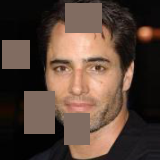

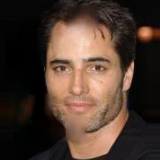

In [43]:
# ======================================
# Make Predictions for masked images
# (masks generated using gen_input_mask)
# ======================================

input_img = 'data_faces/img_align_celeba/test'
rand_test = random.choice(os.listdir('data_faces/img_align_celeba/test')) # choose random test image
input_img = os.path.join(input_img, rand_test)
img_size = 160
max_holes=5
img_size=160
hole_min_w=24
hole_max_w=48
hole_min_h=24
hole_max_h=48

# =============================================
# Predict
# =============================================

# open and convert img to tensor
img = Image.open(input_img)
img = transforms.Resize(img_size)(img)
img = transforms.RandomCrop((img_size, img_size))(img)
x = transforms.ToTensor()(img)
x = torch.unsqueeze(x, dim=0)

# create mask
mask = gen_input_mask(
    shape=(1, 1, x.shape[2], x.shape[3]),
    hole_size=(
        (hole_min_w, hole_max_w),
        (hole_min_h, hole_max_h),
    ),
    max_holes=max_holes,
)
x = x.to(gpu)
mask = mask.to(gpu)

# inpaint and show output
with torch.no_grad():
    x_mask = x - x * mask + mpv * mask
    inputer = torch.cat((x_mask, mask), dim=1)
    output = model_cn(inputer)
    inpainted = poisson_blend(x, output, mask)
    inpainted = inpainted.to(gpu)
    imgs = torch.cat((x_mask, inpainted), dim=0)
    imgs = imgs.to('cpu')
    imgs1 = transforms.functional.to_pil_image(imgs[0])
    imgs2 = transforms.functional.to_pil_image(imgs[1])
    imgs1 = np.array(imgs1)[:, :, [2, 1, 0]]
    imgs2 = np.array(imgs2)[:, :, [2, 1, 0]]
    imgs1 = cv2.cvtColor(imgs1, cv2.COLOR_BGR2RGB) # noisy image
    imgs2 = cv2.cvtColor(imgs2, cv2.COLOR_BGR2RGB) # inpainted noisy image
    imshow(imgs1)
    imshow(imgs2)

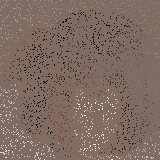

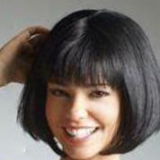

In [126]:
# =========================================
# Make Predictions for masked noisy images
# (OR Denoising Images)
# (masks generated using gen_rand_mask)
# =========================================

input_img = 'data_faces/img_align_celeba/test'
rand_test = random.choice(os.listdir('data_faces/img_align_celeba/test')) # choose random test image
input_img = os.path.join(input_img, rand_test)
img_size = 160

# =============================================
# Predict
# =============================================

# open and convert img to tensor
img = Image.open(input_img)
img = transforms.Resize(img_size)(img)
img = transforms.RandomCrop((img_size, img_size))(img)
x = transforms.ToTensor()(img)
x = torch.unsqueeze(x, dim=0)

# create mask
mask = gen_rand_mask(
    shape=(1, 1, x.shape[2], x.shape[3]),
    p = 0.9
)
x = x.to(gpu)
mask = mask.to(gpu)

# inpaint and show output
with torch.no_grad():
    x_mask = x - x * mask + mpv * mask
    inputer = torch.cat((x_mask, mask), dim=1)
    output = model_cn(inputer)
    inpainted = poisson_blend(x, output, mask)
    inpainted = inpainted.to(gpu)
    imgs = torch.cat((x_mask, inpainted), dim=0)
    imgs = imgs.to('cpu')
    imgs1 = transforms.functional.to_pil_image(imgs[0])
    imgs2 = transforms.functional.to_pil_image(imgs[1])
    imgs1 = np.array(imgs1)[:, :, [2, 1, 0]]
    imgs2 = np.array(imgs2)[:, :, [2, 1, 0]]
    imgs1 = cv2.cvtColor(imgs1, cv2.COLOR_BGR2RGB) # noisy image
    imgs2 = cv2.cvtColor(imgs2, cv2.COLOR_BGR2RGB) # inpainted noisy image
    imshow(imgs1)
    imshow(imgs2)